In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [13]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import os


In [24]:
root_data_folder = "8bit_characters"
image_names = [root_data_folder + "/" + name for name in os.listdir(root_data_folder) if name.endswith(".jpg")]
print(image_names)

['8bit_characters/leonardo_5935302653_o.jpg', '8bit_characters/mysterio_5938497845_o.jpg', '8bit_characters/john-bender_5947476192_o.jpg', '8bit_characters/wheeljack_5982213732_o.jpg', '8bit_characters/spikor_5921532302_o.jpg', '8bit_characters/samus-aran-power-suit_6024447687_o.jpg', '8bit_characters/allison-reynolds_5947475934_o.jpg', '8bit_characters/calypso_5994982128_o.jpg', '8bit_characters/michaelangelo_5935302777_o.jpg', '8bit_characters/neytiri_5925081796_o.jpg', '8bit_characters/mortimer-shadow_5994422753_o.jpg', '8bit_characters/iceman_5938072442_o.jpg', '8bit_characters/lobot_5930961478_o.jpg', '8bit_characters/krista-sparks-grasshopper_5994422531_o.jpg', '8bit_characters/pee-wee-herman_5942000962_o.jpg', '8bit_characters/leeloo_5935305091_o.jpg', '8bit_characters/bamm-bamm_5991957878_o.jpg', '8bit_characters/arwen_5955334313_o.jpg', '8bit_characters/bride-of-frankenstien_5939327360_o.jpg', '8bit_characters/samwise-gamgee_5955895448_o.jpg', '8bit_characters/smitty_595463830

In [25]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

Custom data loader image: https://www.topbots.com/step-by-step-implementation-of-gans-part-2/

In [57]:
X_train = []
count = 0
for dir in image_names:
    try: 
        pixel_size = 50
        img = Image.open(dir)
        img = img.convert("RGB")
        temp = []
        for i in range(0, img.size[0], int(pixel_size/2)):
            row = []
            for j in range(0, img.size[1], int(pixel_size/2)):
                row.append(img.getpixel((i, j)))
            temp.append(row)
        img = np.asarray(temp)/255
        print(img.shape)
        X_train.append(img)
        count += 1
    except Exception as e:
        print(count)
        print(e)

(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute 'append'
(20, 20, 3)
0
'numpy.ndarray' object has no attribute '

In [56]:
X_train = np.asarray(X_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (702,) + inhomogeneous part.

In [51]:
X_train = np.array(X_train)
X_train.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (702,) + inhomogeneous part.

In [43]:
from numpy import savez_compressed

savez_compressed('8bit_characters_32x32.npz', X_train)

In [44]:
dict_data = np.load('8bit_characters_32x32.npz')
 
# extract the first array
data = dict_data['arr_0']
 
# print the array
# print(data)

In [45]:
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")
 
    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

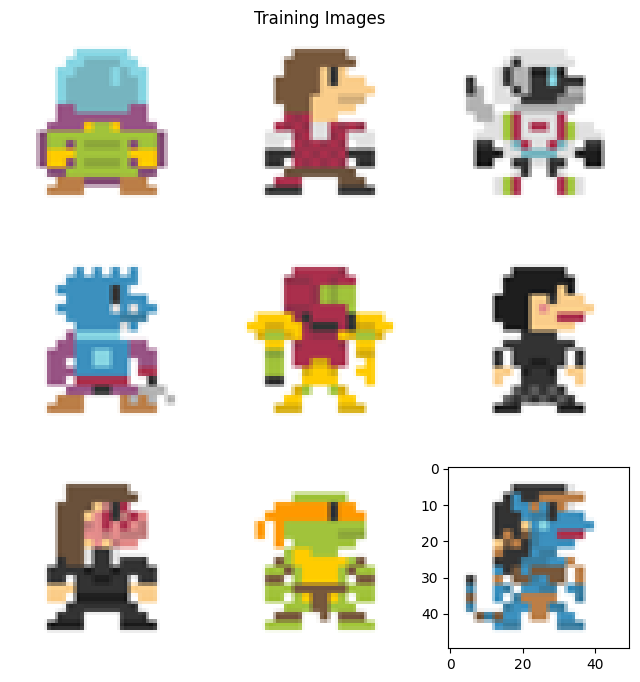

In [46]:
imgs = np.load('8bit_characters_32x32.npz')
 
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)